<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw2/hw2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y  = sample_data()

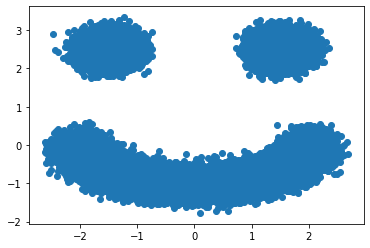

In [417]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [0]:
def loss_(y):
    return -torch.mean(torch.log(y)) / 2

In [0]:
def plot_loss(loss_train, loss_val):
  plt.plot(loss_train, label = "train")
  plt.plot(loss_val, label = "validate")
  plt.legend()
  plt.show()

In [0]:
class MyFlow(nn.Module):
    def __init__(self, k=8):
        super(MyFlow, self).__init__()
        self.k = k
        self.pi1_ = nn.Parameter(torch.randn(k))
        self.softmax = nn.Softmax(dim=-1)
        self.mu1_ = nn.Parameter(torch.randn(k))
        self.sigma1_ = nn.Parameter(torch.randn(k))

        self.hidden = nn.Sequential(nn.Linear(1, 128), nn.ReLU())
        self.pi2_ = nn.Sequential(nn.Linear(128, self.k), nn.Softmax(dim=-1))
        self.mu2_ = nn.Linear(128, self.k)
        self.sigma2_ = nn.Linear(128, self.k)
    
    def get_x2_dist_params(self, x):
        h = self.hidden(x)
        
        return self.pi2_(h), self.mu2_(h), torch.abs(self.sigma2_(h))

    def get_dist_params(self, x):
        x1, x2 = x[:, :1], x[:, 1:]
        self.batch = x1.shape[0]

        pi1, mu1, sigma1 = self.softmax(self.pi1_.repeat(self.batch, 1)), self.mu1_.repeat(self.batch, 1), torch.abs(self.sigma1_.repeat(self.batch, 1))

        h = self.hidden(x1)
        pi2, mu2, sigma2 = self.pi2_(h), self.mu2_(h), torch.abs(self.sigma2_(h))
      
        return pi1, mu1, sigma1, pi2, mu2, sigma2
    
    def forward(self, x):
      x1, x2 = x[:, :1],x[:, 1:]
      self.batch = x1.shape[0]

      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.get_dist_params(x)      

      p1, p2 = torch.zeros(self.batch, 1), torch.zeros(self.batch, 1)

      for i in range(self.k):
        p1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(), (sigma1[:,i:i+1]).float()).log_prob(x1).exp())
        p2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(), (sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
      return p1 * p2

    def __call__(self, x):
        return self.forward(x)

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)
X_train, X_test, X_val, y_train, y_test, y_val = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(X_val), torch.FloatTensor(y_train), torch.FloatTensor(y_test), torch.FloatTensor(y_val)

In [0]:
model = MyFlow().float()
batch_size = 512
epochs_cnt = 16
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train():
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size)
    loss_train, loss_val = [], []

    for epoch in range(epochs_cnt):
        loss_it = []
        
        model.train()
        for batch in train_loader:
            out = model(batch)
            loss = loss_(out)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_it.append(loss.detach().numpy())
        loss_train.append(np.mean(loss_it))
        
        model.eval()
        with torch.no_grad():
            loss_it = []
            for batch in val_loader:
                out = model(batch)
                loss = loss_(out)
                loss_it.append(loss.detach().numpy())
            loss_val.append(np.mean(loss_it))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))

    loss_values = []
    for batch in test_loader:
        out = model(batch)
        loss = loss_(out)
        loss_values.append(loss.item())

    print("Test loss: " + str(np.mean(np.array(loss_values))))
    return loss_train, loss_val

It: 0 Train loss: 2.0542295 Val loss: 1.4833407
It: 1 Train loss: 1.2645944 Val loss: 1.155091
It: 2 Train loss: 1.0790228 Val loss: 1.0046374
It: 3 Train loss: 0.96052766 Val loss: 0.9060923
It: 4 Train loss: 0.8792835 Val loss: 0.8388413
It: 5 Train loss: 0.81653374 Val loss: 0.7865957
It: 6 Train loss: 0.77060336 Val loss: 0.7405673
It: 7 Train loss: 0.73057634 Val loss: 0.71292675
It: 8 Train loss: 0.70270145 Val loss: 0.68727463
It: 9 Train loss: 0.68844694 Val loss: 0.68042564
It: 10 Train loss: 0.68495643 Val loss: 0.67929554
It: 11 Train loss: 0.68415374 Val loss: 0.6763111
It: 12 Train loss: 0.68158084 Val loss: 0.6751819
It: 13 Train loss: 0.68020976 Val loss: 0.6765871
It: 14 Train loss: 0.67972004 Val loss: 0.6742616
It: 15 Train loss: 0.6785506 Val loss: 0.6729217
Test loss: 0.6765942364931107


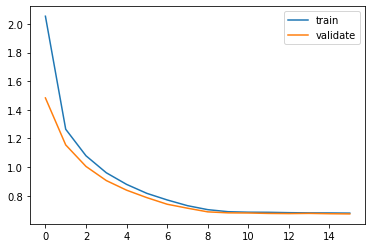

In [424]:
loss_train, loss_val = train()
plot_loss(loss_train, loss_val)

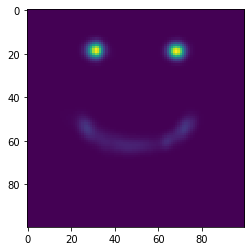

In [425]:
space = np.linspace(-4, 4, 100)
samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float()
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

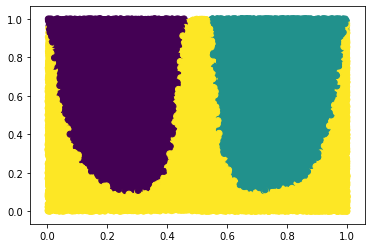

In [426]:
pi1, mu1, sigma1, pi2, mu2, sigma2 = model.get_dist_params(X_train)
      
z1, z2 = torch.zeros(model.batch,1), torch.zeros(model.batch,1)
      
x1, x2 = X_train[:, :1], X_train[:, 1:]
      
for i in range(model.k):
    z1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).cdf(x1))
    z2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).cdf(x2))

plt.figure()
plt.scatter(z1[:, 0].detach().numpy(), z2[:, 0].detach().numpy(), c=y_train)
plt.show()

In [0]:
def probs_sample(pi, sigmasq, mu, samples):
  N, K = pi.shape
  out = Variable(torch.zeros(N, samples, 1))
  for i in range(N):
    for j in range(samples):
      u = np.random.uniform()
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          sample = np.random.normal(mu.data[i, k], np.sqrt(sigmasq.data[i, k]))
          out[i, j, 0] = sample
          break
  return out

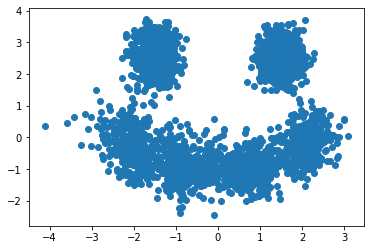

In [429]:
pi1, mu1, sigma1 = model.softmax(model.pi1_.view(1,-1)), model.mu1_.view(1,-1), torch.abs(model.sigma1_).view(1,-1)
p1 = probs_sample(pi1, sigma1, mu1, samples=3000)
pi2, mu2, sigma2 = model.get_x2_dist_params(p1)
p2 = probs_sample(pi2[0], sigma2[0], mu2[0], samples=1)
plt.figure()
plt.scatter(p1, p2)
plt.show()